In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.integrate import solve_ivp

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        identity = x
        out = self.activation(self.linear1(x))
        out = self.linear2(out)
        return self.activation(out + identity)

In [4]:
class PINN(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=8):
        super().__init__()
        
        # Physical parameters
        self.m1 = 1.0
        self.m2 = 1.0
        self.L1 = 1.0
        self.L2 = 1.0
        self.g = 9.81
        
        # Input layer
        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        
        # Residual blocks
        for _ in range(num_layers):
            layers.append(ResidualBlock(hidden_dim))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, 4))
        
        self.network = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, t):
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)
        return self.network(t)
    
    def compute_derivatives(self, t):
        """Compute derivatives with higher precision"""
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)
        t = t.to(device)
        t.requires_grad_(True)
        
        y = self.forward(t)
        theta1, theta2 = y[:, 0:1], y[:, 1:2]
        omega1, omega2 = y[:, 2:3], y[:, 3:4]
        
        # Compute gradients with higher precision
        dtheta1_dt = torch.autograd.grad(theta1.sum(), t, create_graph=True)[0]
        dtheta2_dt = torch.autograd.grad(theta2.sum(), t, create_graph=True)[0]
        domega1_dt = torch.autograd.grad(omega1.sum(), t, create_graph=True)[0]
        domega2_dt = torch.autograd.grad(omega2.sum(), t, create_graph=True)[0]
        
        first_derivatives = torch.cat([dtheta1_dt, dtheta2_dt, domega1_dt, domega2_dt], dim=1)
        
        d2theta1_dt2 = torch.autograd.grad(dtheta1_dt.sum(), t, create_graph=True)[0]
        d2theta2_dt2 = torch.autograd.grad(dtheta2_dt.sum(), t, create_graph=True)[0]
        
        second_derivatives = torch.cat([d2theta1_dt2, d2theta2_dt2], dim=1)
        
        return first_derivatives, second_derivatives
    
    def physics_loss(self, t):
        """Compute physics loss with relative error terms"""
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)
        t = t.to(device)
        y = self.forward(t)
        theta1, theta2 = y[:, 0:1], y[:, 1:2]
        omega1, omega2 = y[:, 2:3], y[:, 3:4]
        
        first_derivs, second_derivs = self.compute_derivatives(t)
        d2theta1_dt2, d2theta2_dt2 = second_derivs[:, 0:1], second_derivs[:, 1:2]
        
        delta = theta2 - theta1
        sin_delta = torch.sin(delta)
        cos_delta = torch.cos(delta)
        
        # Equations of motion terms
        a1 = (self.m1 + self.m2) * self.L1
        a2 = self.m2 * self.L2 * cos_delta
        b1 = -self.m2 * self.L2 * omega2**2 * sin_delta
        b2 = -(self.m1 + self.m2) * self.g * torch.sin(theta1)
        
        c1 = self.m2 * self.L2
        c2 = self.m2 * self.L1 * cos_delta
        d1 = self.m2 * self.L1 * omega1**2 * sin_delta
        d2 = -self.m2 * self.g * torch.sin(theta2)
        
        # Compute residuals
        eq1_residual = a1 * d2theta1_dt2 + a2 * d2theta2_dt2 - (b1 + b2)
        eq2_residual = c1 * d2theta2_dt2 + c2 * d2theta1_dt2 - (d1 + d2)
        
        # Relative error terms
        eq1_scale = torch.mean(torch.abs(a1 * d2theta1_dt2)) + 1e-10
        eq2_scale = torch.mean(torch.abs(c1 * d2theta2_dt2)) + 1e-10
        
        # Weighted relative loss
        physics_loss = torch.mean((eq1_residual/eq1_scale)**2 + (eq2_residual/eq2_scale)**2)
        
        # Add conservation of energy constraint
        E_kinetic = 0.5 * self.m1 * self.L1**2 * omega1**2 + \
                   0.5 * self.m2 * (self.L1**2 * omega1**2 + self.L2**2 * omega2**2 + \
                   2 * self.L1 * self.L2 * omega1 * omega2 * cos_delta)
        E_potential = -(self.m1 + self.m2) * self.g * self.L1 * torch.cos(theta1) - \
                     self.m2 * self.g * self.L2 * torch.cos(theta2)
        
        E_total = E_kinetic + E_potential
        energy_loss = torch.mean((E_total[1:] - E_total[:-1])**2) if len(E_total) > 1 else torch.tensor(0.0).to(device)
        
        return physics_loss + 0.1 * energy_loss
    
    def initial_conditions_loss(self, t0, theta1_0, theta2_0, omega1_0, omega2_0):
        """Compute loss for initial conditions"""
        t_init = torch.tensor([[t0]], dtype=torch.float32).to(device)
        y_init = self.forward(t_init)
        
        ic_loss = torch.mean((y_init[0, 0] - theta1_0)**2 +
                           (y_init[0, 1] - theta2_0)**2 +
                           (y_init[0, 2] - omega1_0)**2 +
                           (y_init[0, 3] - omega2_0)**2)
        
        return ic_loss

In [5]:
class DomainDecompositionPINN:
    def __init__(self, n_subdomains=5, hidden_dim=128, num_layers=8):
        self.n_subdomains = n_subdomains
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Create separate networks for each subdomain
        self.sub_networks = []
        for _ in range(n_subdomains):
            net = PINN(hidden_dim, num_layers).to(self.device)
            # Asegurar que todos los parámetros sean float32
            net.double().float()  # Convertir explícitamente a float32
            self.sub_networks.append(net)
            
        # Physical parameters
        self.m1 = torch.tensor(1.0, dtype=torch.float32, device=self.device)
        self.m2 = torch.tensor(1.0, dtype=torch.float32, device=self.device)
        self.L1 = torch.tensor(1.0, dtype=torch.float32, device=self.device)
        self.L2 = torch.tensor(1.0, dtype=torch.float32, device=self.device)
        self.g = torch.tensor(9.81, dtype=torch.float32, device=self.device)
    
    def get_subdomain_boundaries(self, t_domain):
        """Calculate boundaries for each subdomain"""
        t_start, t_end = t_domain
        boundaries = np.linspace(t_start, t_end, self.n_subdomains + 1)
        return boundaries.astype(np.float32)
    
    def compute_loss(self, t, theta1_0, theta2_0, omega1_0, omega2_0, alpha=0.99):
        """Compute total loss with domain decomposition"""
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)
        t = t.to(self.device, dtype=torch.float32)
        
        # Initial conditions loss for first subdomain
        ic_loss = self.sub_networks[0].initial_conditions_loss(
            t[0].item(), 
            torch.tensor(theta1_0, dtype=torch.float32, device=self.device),
            torch.tensor(theta2_0, dtype=torch.float32, device=self.device),
            torch.tensor(omega1_0, dtype=torch.float32, device=self.device),
            torch.tensor(omega2_0, dtype=torch.float32, device=self.device)
        )
        
        # Physics loss for all subdomains
        physics_loss = torch.tensor(0.0, dtype=torch.float32, device=self.device)
        boundaries = self.get_subdomain_boundaries((t.min().item(), t.max().item()))
        
        for i in range(self.n_subdomains):
            mask = (t >= boundaries[i]) & (t <= boundaries[i+1])
            if not mask.any():
                continue
                
            subnet = self.sub_networks[i]
            physics_loss += subnet.physics_loss(t[mask])
            
            # Continuity constraints at subdomain boundaries
            if i > 0:
                t_boundary = torch.tensor([[boundaries[i]]], 
                                        dtype=torch.float32, 
                                        device=self.device)
                prev_output = self.sub_networks[i-1](t_boundary)
                curr_output = subnet(t_boundary)
                physics_loss += torch.mean((prev_output - curr_output)**2)
        
        return alpha * ic_loss + (1 - alpha) * physics_loss

In [6]:
class DoublePendulum:
    """Class to compute the true solution using numerical integration"""
    def __init__(self, m1=1.0, m2=1.0, L1=1.0, L2=1.0, g=9.81):
        self.m1, self.m2 = m1, m2
        self.L1, self.L2 = L1, L2
        self.g = g
        
    def equations_of_motion(self, t, state):
        """
        Returns the derivatives of the state variables
        state = [theta1, theta2, omega1, omega2]
        """
        theta1, theta2, omega1, omega2 = state
        
        # Pre-compute repeated terms
        m1, m2 = self.m1, self.m2
        L1, L2 = self.L1, self.L2
        g = self.g
        
        delta = theta2 - theta1
        sin_delta = np.sin(delta)
        cos_delta = np.cos(delta)
        
        # Matrix elements for the system of equations
        den = (m1 + m2) * L1 * L2 - m2 * L1 * L2 * cos_delta**2
        
        # Angular accelerations
        alpha1_num = (m2 * L2 * omega2**2 * sin_delta * cos_delta +
                     m2 * g * np.sin(theta2) * cos_delta -
                     m2 * L2 * omega1**2 * sin_delta -
                     (m1 + m2) * g * np.sin(theta1))
        
        alpha2_num = (-m2 * L2 * omega2**2 * sin_delta * cos_delta +
                     (m1 + m2) * (L1 * omega1**2 * sin_delta -
                                 g * np.sin(theta2) +
                                 g * np.sin(theta1) * cos_delta))
        
        alpha1 = L2 * alpha1_num / den
        alpha2 = L1 * alpha2_num / den
        
        return [omega1, omega2, alpha1, alpha2]
    
    def solve(self, t_span, initial_conditions, t_eval=None):
        """Solve the system for given time span and initial conditions"""
        solution = solve_ivp(
            self.equations_of_motion,
            t_span,
            initial_conditions,
            method='RK45',
            t_eval=t_eval,
            rtol=1e-10,
            atol=1e-10
        )
        return solution

In [7]:
def train_decomposed_pinn(model: DomainDecompositionPINN, 
                         t_domain: Tuple[float, float],
                         n_points: int = 2000,
                         n_epochs: int = 200,
                         batch_size: int = 200):
    """Train the domain-decomposed PINN"""
    
    # Generate time points with logarithmic spacing for each subdomain
    boundaries = model.get_subdomain_boundaries(t_domain)
    t_points = []
    
    for i in range(len(boundaries)-1):
        t_local = np.linspace(boundaries[i], boundaries[i+1], 
                             n_points//model.n_subdomains)
        t_points.append(t_local)
    
    t = np.concatenate(t_points).astype(np.float32)
    t = torch.tensor(t, dtype=torch.float32)
    
    # Initial conditions
    theta1_0, theta2_0 = np.pi/2, np.pi/2
    omega1_0, omega2_0 = 0.0, 0.0
    
    # Create optimizers for each subdomain
    optimizers = [
        torch.optim.Adam(net.parameters(), lr=0.001)
        for net in model.sub_networks
    ]
    
    schedulers = [
        torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=100)
        for opt in optimizers
    ]
    
    dataset = torch.utils.data.TensorDataset(t.unsqueeze(-1))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    losses = []
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        for batch_t, in dataloader:
            # Zero all gradients
            for opt in optimizers:
                opt.zero_grad()
            
            # Compute total loss
            total_loss = model.compute_loss(
                batch_t, theta1_0, theta2_0, omega1_0, omega2_0
            )
            
            total_loss.backward()
            
            # Step all optimizers
            for opt in optimizers:
                opt.step()
            
            epoch_loss += total_loss.item()
            batch_count += 1
        
        avg_epoch_loss = epoch_loss / batch_count
        losses.append(avg_epoch_loss)
        
        # Update learning rates
        for scheduler in schedulers:
            scheduler.step(avg_epoch_loss)
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {avg_epoch_loss:.6f}')
        
        # Early stopping if all learning rates are too small
        if all(opt.param_groups[0]['lr'] < 1e-6 for opt in optimizers):
            print("Early stopping triggered")
            break
    
    return losses

In [12]:
def plot_solution_comparison(model: DomainDecompositionPINN, t_domain: tuple, n_points: int = 1000):
    """Plot comparison between PINN solution and true solution"""
    import matplotlib.pyplot as plt
    
    # Generate time points
    t = np.linspace(t_domain[0], t_domain[1], n_points)
    t_tensor = torch.tensor(t, dtype=torch.float32, device=model.device).unsqueeze(-1)
    
    # Get PINN solution using domain decomposition
    boundaries = model.get_subdomain_boundaries(t_domain)
    pinn_solution = []
    
    with torch.no_grad():
        for i in range(model.n_subdomains):
            mask = (t_tensor >= boundaries[i]) & (t_tensor <= boundaries[i+1])
            if not mask.any():
                continue
            
            subnet_solution = model.sub_networks[i](t_tensor[mask])
            pinn_solution.append(subnet_solution.cpu().numpy())
    
    pinn_solution = np.concatenate(pinn_solution, axis=0)
    
    # Get true solution
    pendulum = DoublePendulum(
        m1=model.m1.item(), 
        m2=model.m2.item(),
        L1=model.L1.item(), 
        L2=model.L2.item(),
        g=model.g.item()
    )
    
    true_sol = pendulum.solve(
        t_domain,
        [np.pi/2, np.pi/2, 0.0, 0.0],
        t_eval=t
    )
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot theta1
    axes[0, 0].plot(t, true_sol.y[0], 'b-', label='True')
    axes[0, 0].plot(t, pinn_solution[:, 0], 'r--', label='PINN')
    axes[0, 0].set_title('θ₁')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot theta2
    axes[0, 1].plot(t, true_sol.y[1], 'b-', label='True')
    axes[0, 1].plot(t, pinn_solution[:, 1], 'r--', label='PINN')
    axes[0, 1].set_title('θ₂')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot omega1
    axes[1, 0].plot(t, true_sol.y[2], 'b-', label='True')
    axes[1, 0].plot(t, pinn_solution[:, 2], 'r--', label='PINN')
    axes[1, 0].set_title('ω₁')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot omega2
    axes[1, 1].plot(t, true_sol.y[3], 'b-', label='True')
    axes[1, 1].plot(t, pinn_solution[:, 3], 'r--', label='PINN')
    axes[1, 1].set_title('ω₂')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    return fig, axes

In [9]:
# Create model
model = DomainDecompositionPINN(n_subdomains=5)

In [10]:
# Train model
t_domain = (0.0, 2.0)
losses = train_decomposed_pinn(model, t_domain)

Epoch 0, Loss: 26.126073
Epoch 100, Loss: 0.013290


(<Figure size 1500x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'θ₁'}>, <Axes: title={'center': 'θ₂'}>],
        [<Axes: title={'center': 'ω₁'}>, <Axes: title={'center': 'ω₂'}>]],
       dtype=object))

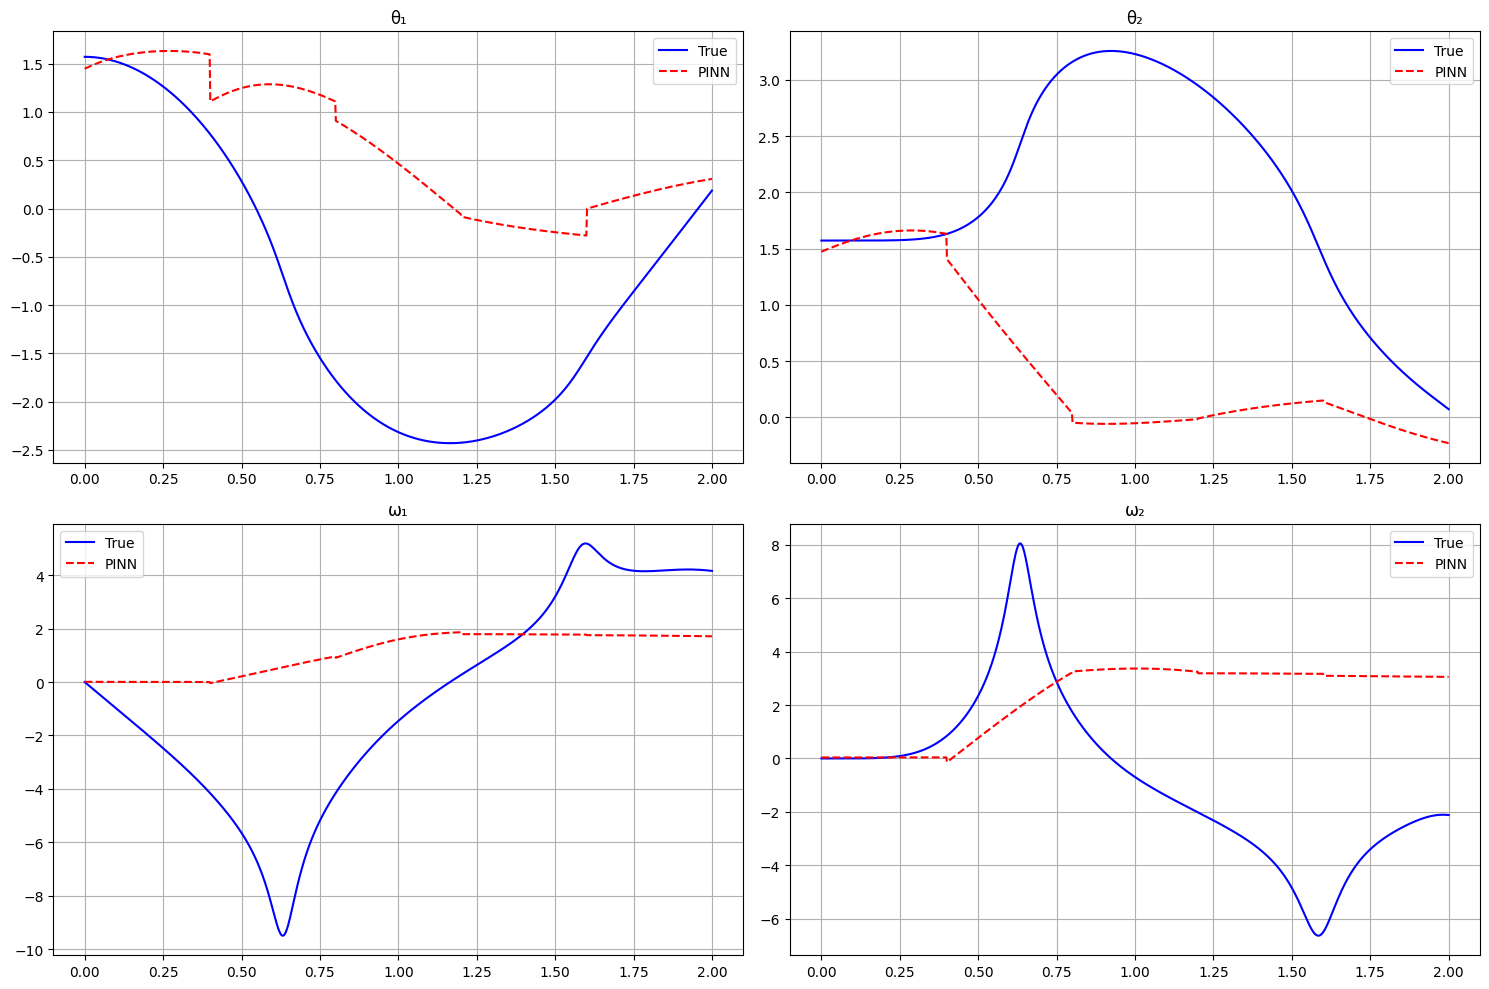

In [13]:
# Plot comparison with true solution
plot_solution_comparison(model, t_domain)